In [134]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [135]:
import matplotlib
import matplotlib.pyplot as plt
import glob
import math
import numpy as np
#import pandas as pd
from bisect import *
from decimal import Decimal
#from scipy.optimize import curve_fit
#import scipy.special as sps

In [136]:
def parseCountsNorm(di,denName):
    do = {}
    for wf in di :
      den = 1.
      if (denName!='') : den = di[wf][denName]
      if (denName=='seconds') : den*=1000.*1000.*1000.
      for k in di[wf] :
        ko = k
        if (k=='msec') :
          ko='nsec'
        if(k=='seconds') : ko='wall-clock-ns'
        if not ko in do : do[ko] = {}
        do[ko][wf] = di[wf][k]/den
        if (ko=='nsec') :  do[ko][wf]*=1000.*1000.
        if (ko=='wall-clock-ns') :  do[ko][wf]*=1000*1000.*1000.
    return do


def doPrint(di) :
  s = '|' + ' | '
  for wf  in di['cycles'] :
    s+= ' ' + wf + ' |'
  s += '|'
  print(s)
  for k in di :
    s = '|' + k + ' | '
    for wf  in di[k] :
        v = di[k][wf]
        s+= ' ' + "{:6.4f}".format(v)  + ' | '
    s += '|'
    print(s)


def parseOne(fname) :
  nop=0
  d ={}
  with open(fname) as f:
    print('\n\n---++ '+fname)
    for line in f:
      try:
        (wf, val, key) = line.split()
        d[wf] = {}
      except:
        nop+=1
  with open(fname) as f:
    for line in f:
      try:
        (wf, val, key) = line.split()
        d[wf][key]= float(val)
      except:
        nop+=1
#
  dr = parseCountsNorm(d,'')
  dc = parseCountsNorm(d,'cycles')
  di = parseCountsNorm(d,'instructions')
  ds = parseCountsNorm(d,'seconds')
  return [dc,di,ds,dr]

In [137]:
dir = '/Users/innocent/cernbox/HepSpec/'
files = [dir+"Haswell/haswell.count",dir+"Skylake/skylake.count",dir+"Icelake/icelake.count"]
#files = [dir+"Haswell/haswellFull.count",dir+"Skylake/skylakeFull.count",dir+"Icelake/icelakeFull.count"]
scores={}
scores['Haswell']=parseOne(files[0])
scores['Skylake']=parseOne(files[1])
scores['Icelake']=parseOne(files[2])



---++ /Users/innocent/cernbox/HepSpec/Haswell/haswell.count


---++ /Users/innocent/cernbox/HepSpec/Skylake/skylake.count


---++ /Users/innocent/cernbox/HepSpec/Icelake/icelake.count


In [138]:
norNames = ['cycles','instructions','wall-clock','']
di = scores['Haswell'][0]['cycles']
labels = []
for wf in di : labels.append(wf)
print(labels)

['aliceSim10', 'atlaSim10', 'atlasGen500', 'atlasReco200', 'cmsDigi100', 'cmsRecoDQM100', 'cmsSim50', 'igwn', 'lhcbSim100']


In [145]:
def plotIt(var,nor) :
    norName = norNames[nor]
    plt.rcParams["figure.figsize"] = (15,6)
    haswell = []
    skylake = []
    icelake = []
    dh = scores['Haswell'][nor][var]
    for wf in dh : haswell.append(dh[wf])
    ds = scores['Skylake'][nor][var]
    for wf in ds : skylake.append(ds[wf])
    di = scores['Icelake'][nor][var]
    for wf in di : icelake.append(di[wf])
  
    x = np.arange(len(labels))  # the label locations
    width = 0.2  # the width of a bar

    fig, ax = plt.subplots()
    rects3 = ax.bar(x + width/2, icelake, width, label='Icelake')
    rects2 = ax.bar(x - width/2, skylake, width, label='Skylake')
    rects1 = ax.bar(x - 3*width/2, haswell, width, label='Haswell')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    label = var
    if (len(norName)>0) : label = var+'/'+norName
    ax.set_ylabel(label)
    ax.set_title(label)
    ax.set_xticks(x,labels)
    ax.legend()

    ax.bar_label(rects1, padding=3)
    ax.bar_label(rects2, padding=3)
    ax.bar_label(rects3, padding=3)

    # fig.tight_layout()

    plt.show()

    skylake = []
    icelake = []
    for wf in ds : skylake.append(ds[wf]/dh[wf])
    for wf in di : icelake.append(di[wf]/dh[wf])
    width = 0.4  # the width of a bar
    fig, ax = plt.subplots()
    rects3 = ax.bar(x + width/2, icelake, width, label='Icelake')
    rects2 = ax.bar(x - width/2, skylake, width, label='Skylake')
    label = var
    if (len(norName)>0) : label = var+'/'+norName
    ax.set_ylabel(label)
    ax.set_title(label+' (normalize to Haswell)')
    ax.set_xticks(x,labels)
    ax.legend()

    ax.bar_label(rects2, padding=3)
    ax.bar_label(rects3, padding=3)

    # fig.tight_layout()

    plt.show()




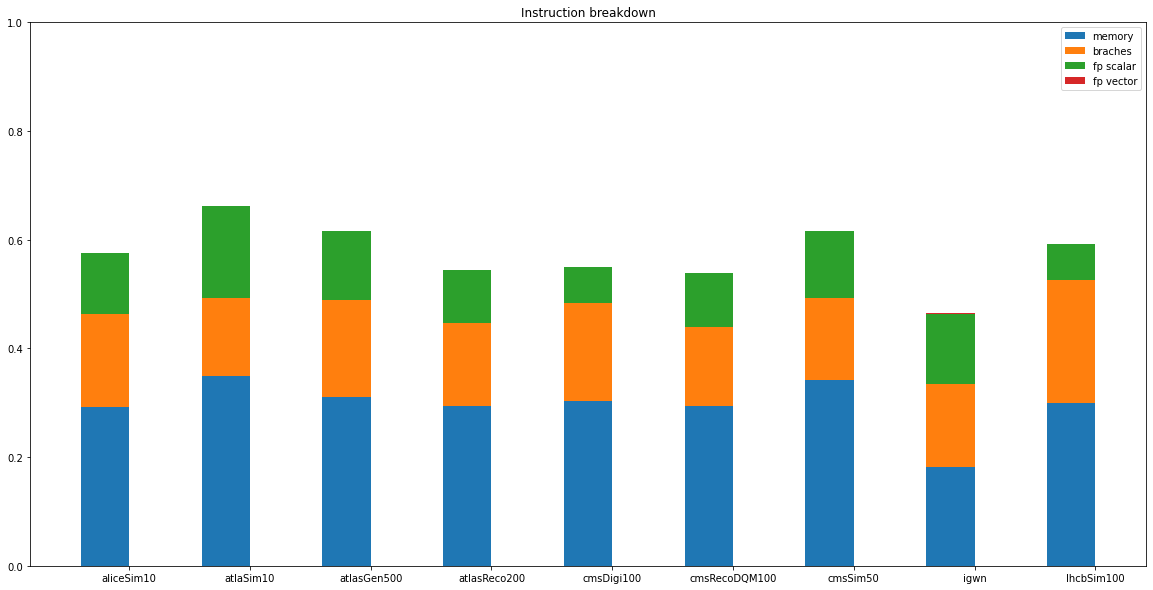

In [160]:
def doSum(vars,nor) :
    di = scores['Icelake'][nor]
    ret = []
    for wf in labels :
        q = 0.
        for var in vars : q += di[var][wf]
        ret.append(q)
    return ret

def instrBD() :
    plt.rcParams["figure.figsize"] = (20,10)
    mem = ['mem_load_retired.l1_hit','mem_load_retired.l2_hit','mem_load_retired.l3_hit','mem_load_retired.l3_miss']
    fpv = ['fp_arith_inst_retired.256b_packed_single','fp_arith_inst_retired.256b_packed_double','fp_arith_inst_retired.512b_packed_single','fp_arith_inst_retired.512b_packed_double']
    fps = ['fp_arith_inst_retired.scalar_single','fp_arith_inst_retired.scalar_double']
    br = ['branch-instructions']
    x = np.arange(len(labels))  # the label locations
    width = 0.4  # the width of a bar

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, doSum(mem,1), width, label='memory')
    all = mem
    rects2 = ax.bar(x - width/2, doSum(br,1), width, label='braches',bottom=doSum(all,1))
    all += br
    rects3 = ax.bar(x - width/2, doSum(fps,1), width, label='fp scalar',bottom=doSum(all,1))
    all += fps
    rects4 = ax.bar(x - width/2, doSum(fpv,1), width, label='fp vector',bottom=doSum(all,1))
    ax.set_ylim(0.,1.)
    ax.set_title('Instruction breakdown')
    ax.set_xticks(x,labels)
    ax.legend()
    plt.show()

instrBD()
    

In [140]:
def plotOne(var,nor) :
    norName = norNames[nor]
    plt.rcParams["figure.figsize"] = (12,4)
    icelake = []
    di = scores['Icelake'][nor][var]
    for wf in di : icelake.append(di[wf])
  
    x = np.arange(len(labels))  # the label locations
    width = 0.4  # the width of a bar

    fig, ax = plt.subplots()
    rects2 = ax.bar(x - width/2, icelake, width, label='Icelake')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    label = var
    if (len(norName)>0) : label = var+'/'+norName
    ax.set_ylabel(label)
    ax.set_title(label)
    ax.set_xticks(x,labels)
    ax.legend()
    ax.bar_label(rects2, padding=3)


    # fig.tight_layout()

    plt.show()

def plotSum(vars,nor,title) :
    norName = norNames[nor]
    plt.rcParams["figure.figsize"] = (12,4)
    icelake = []
    di = scores['Icelake'][nor]
    for wf in labels :
        q = 0.
        for var in vars : q += di[var][wf]
        icelake.append(q)
  
    x = np.arange(len(labels))  # the label locations
    width = 0.4  # the width of a bar

    fig, ax = plt.subplots()
    rects2 = ax.bar(x - width/2, icelake, width, label='Icelake')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel(title+'/'+norName)
    ax.set_title(title)
    ax.set_xticks(x,labels)
    ax.legend()
    ax.bar_label(rects2, padding=3)


    # fig.tight_layout()

    plt.show()


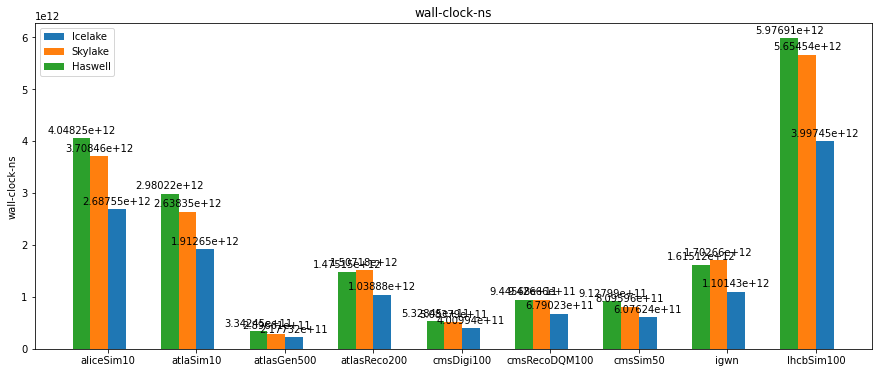

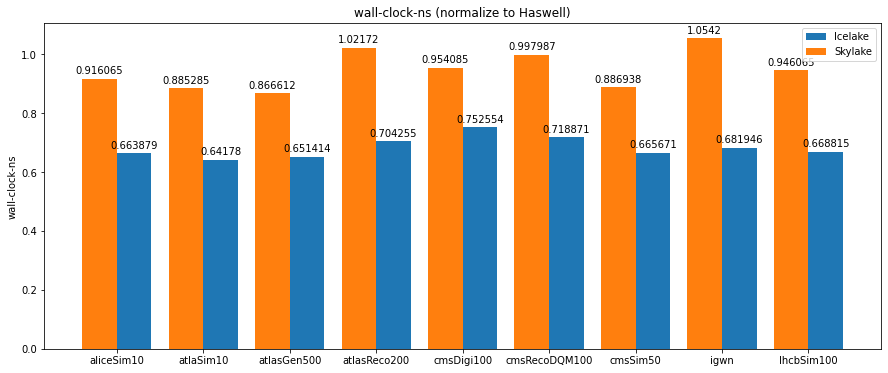

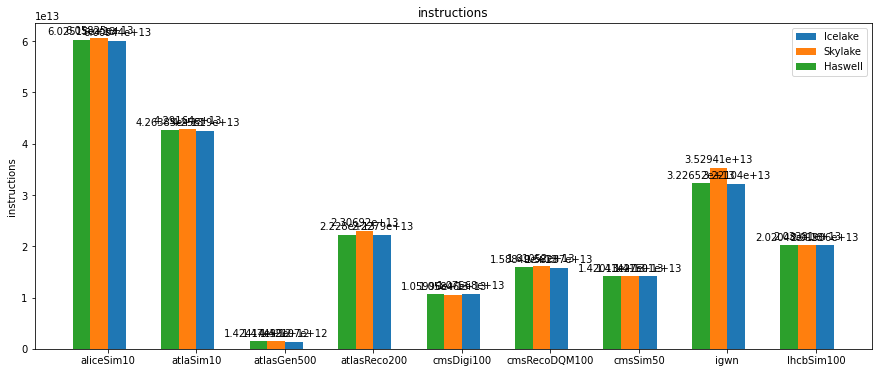

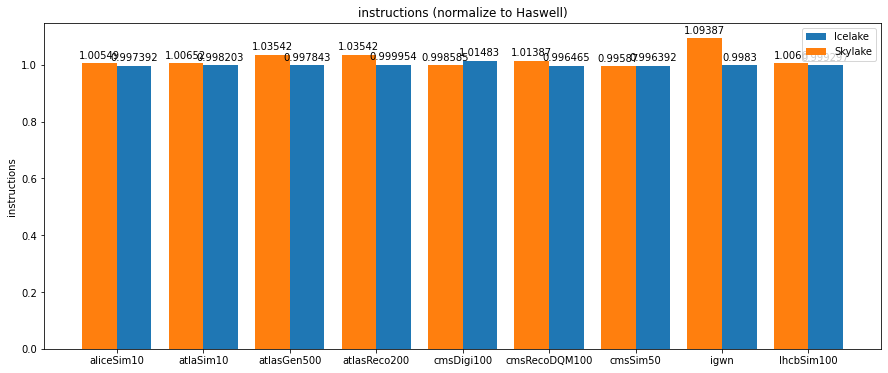

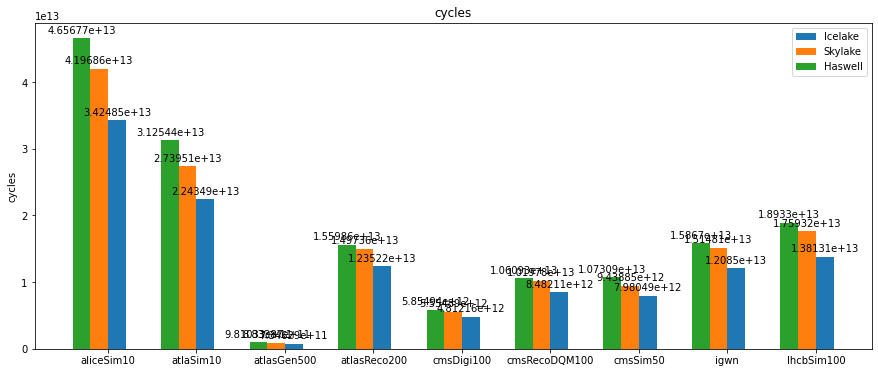

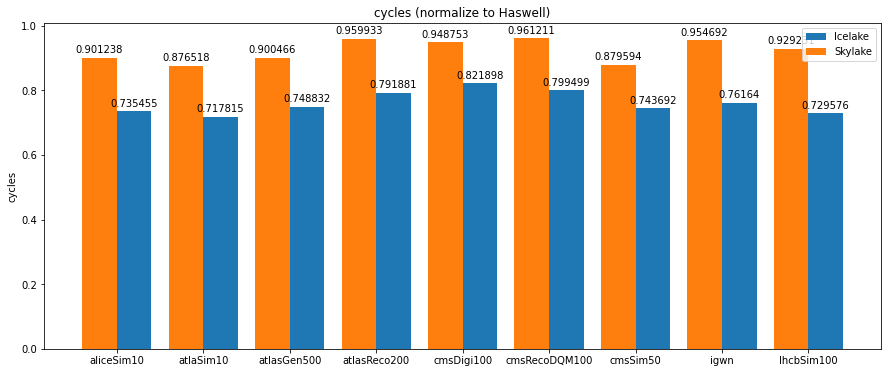

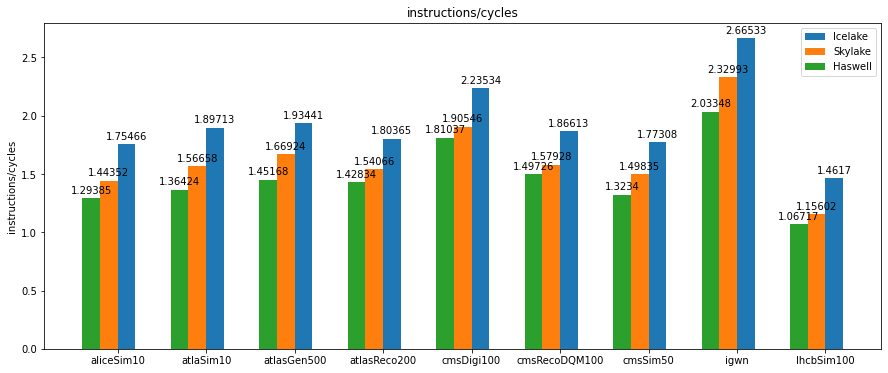

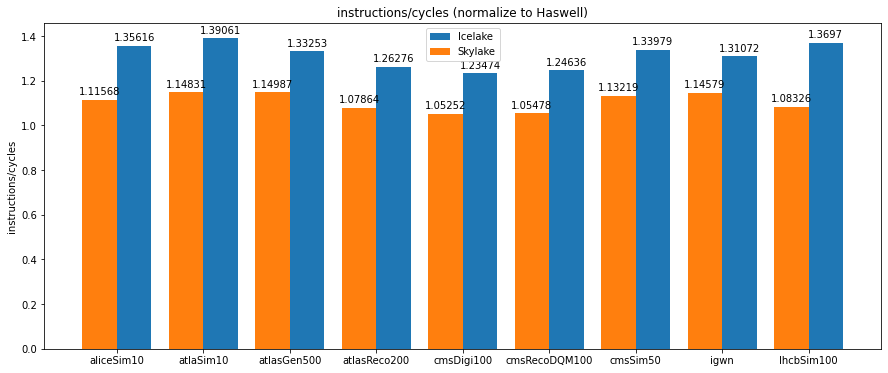

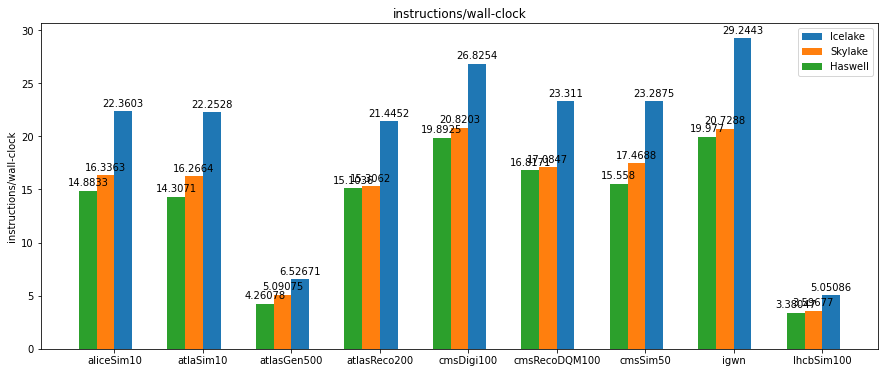

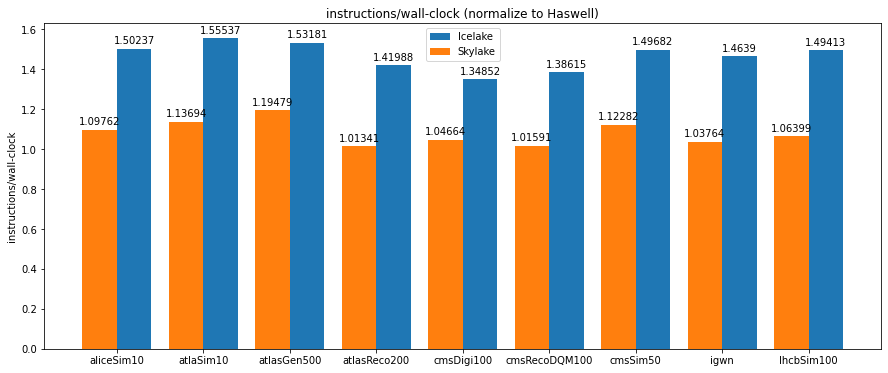

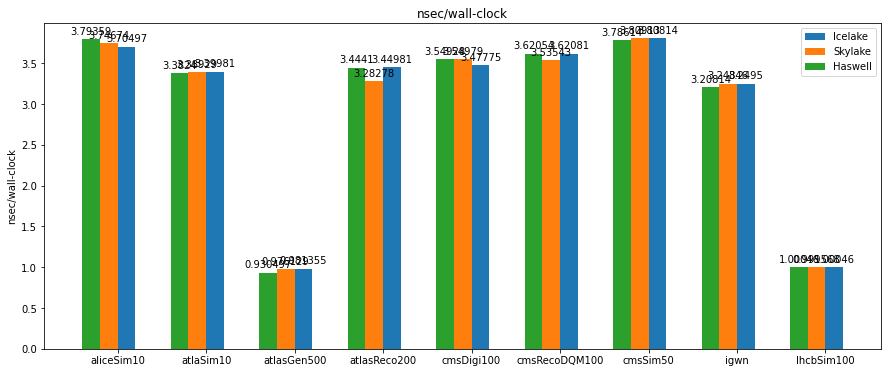

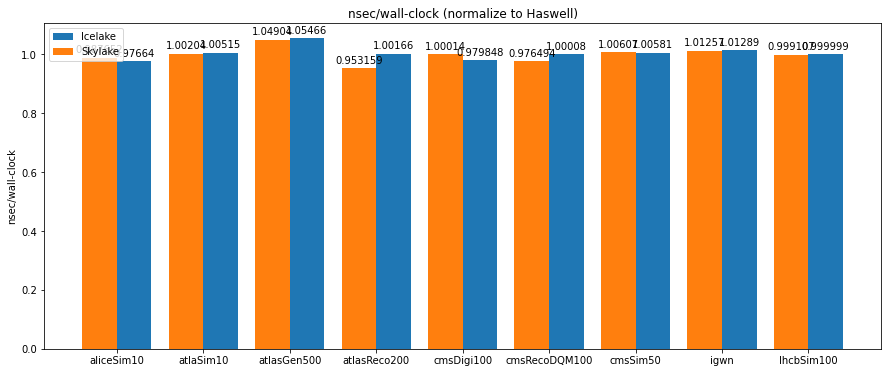

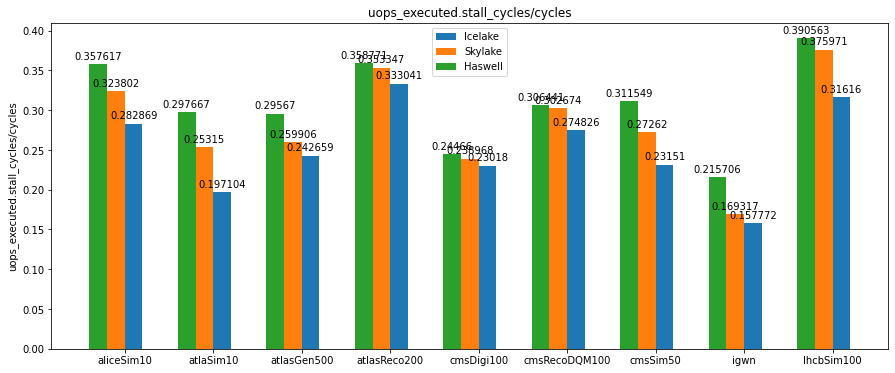

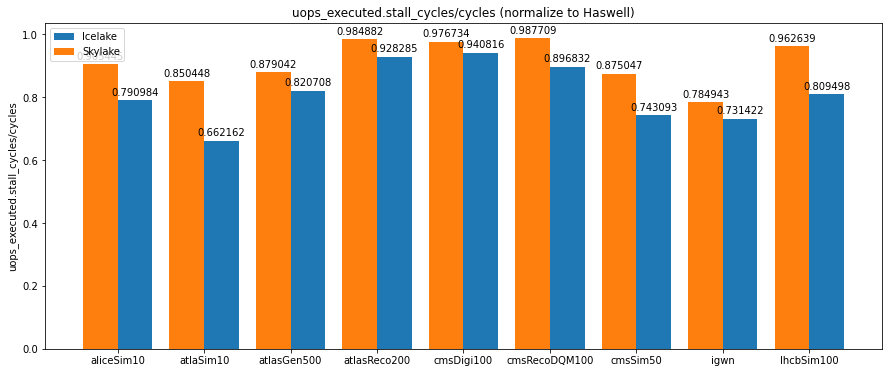

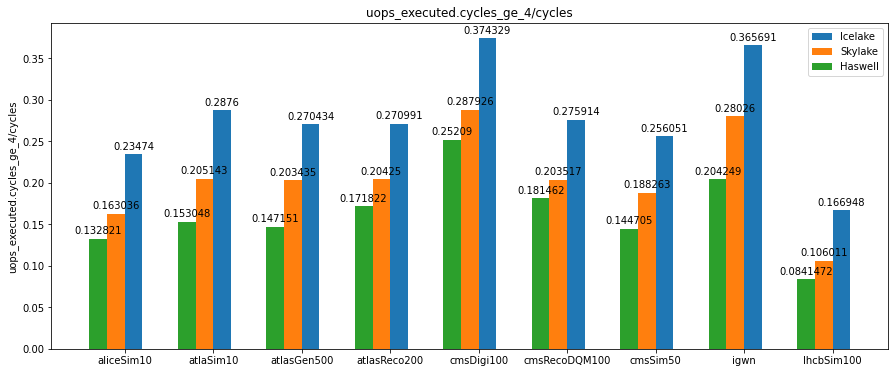

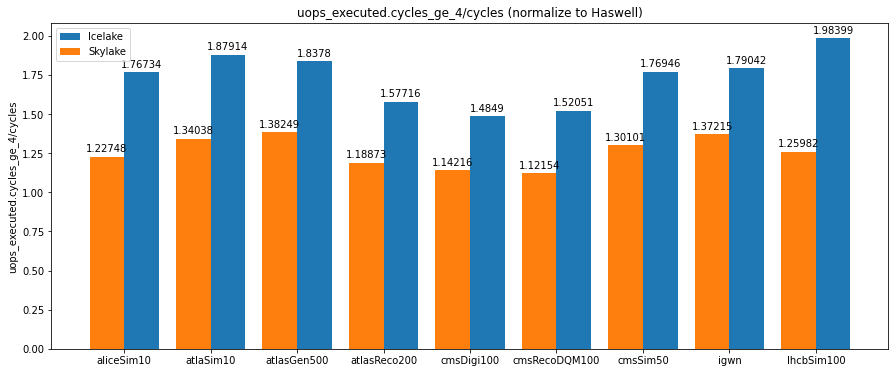

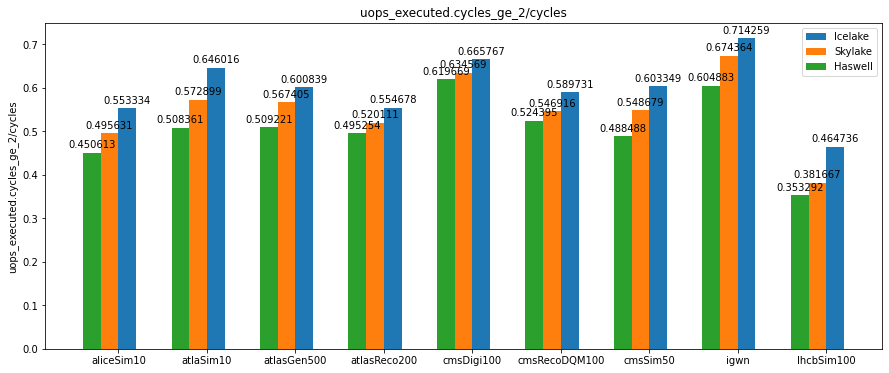

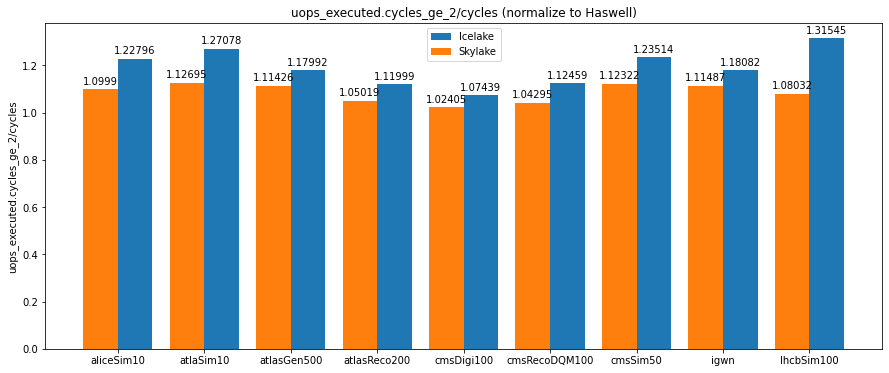

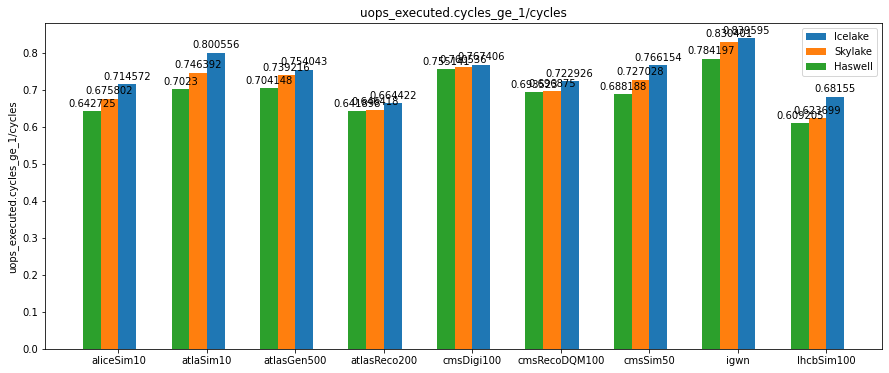

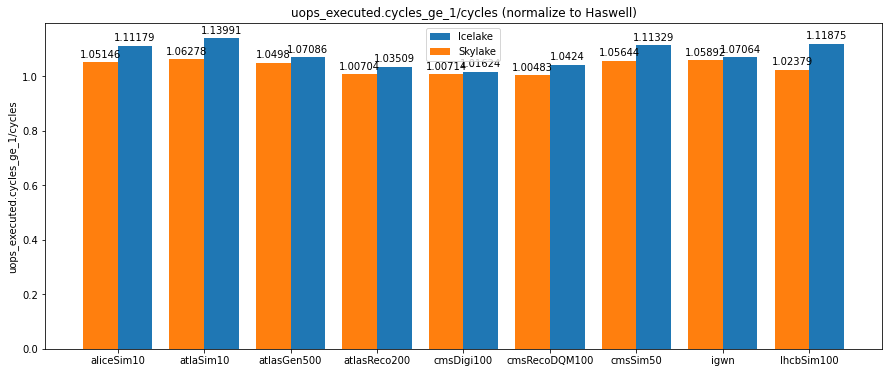

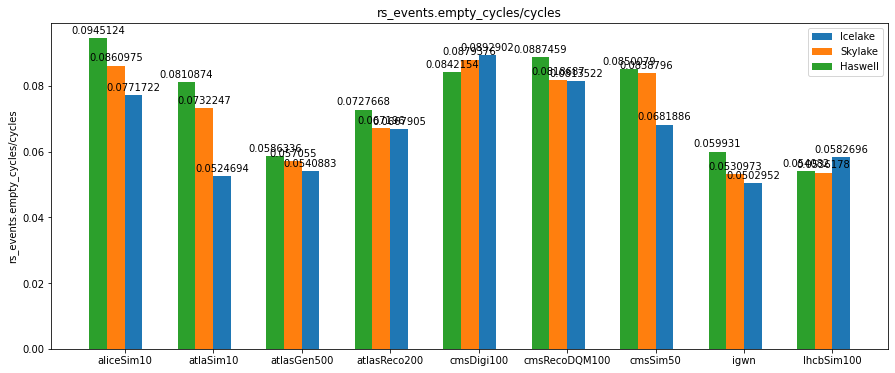

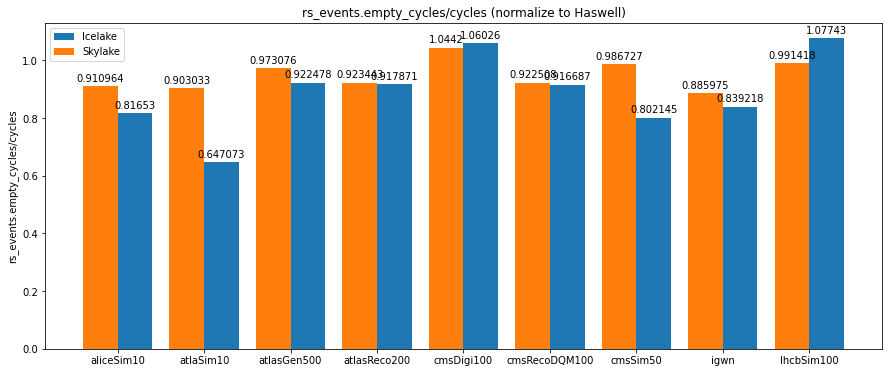

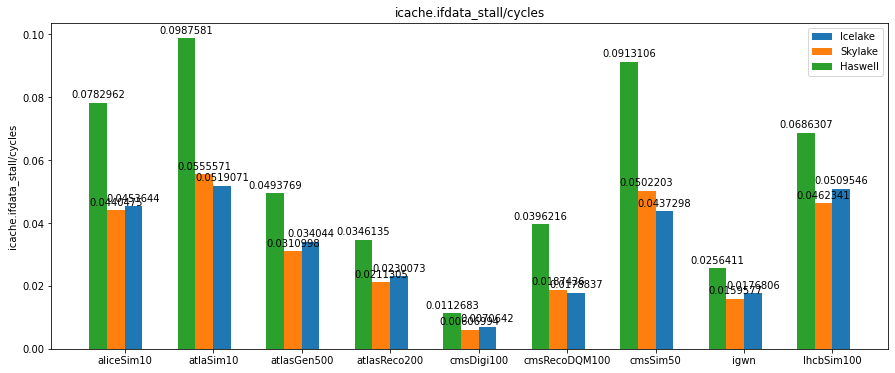

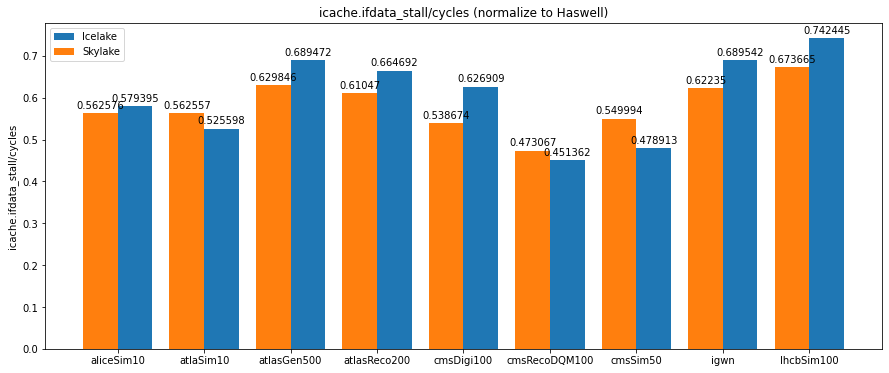

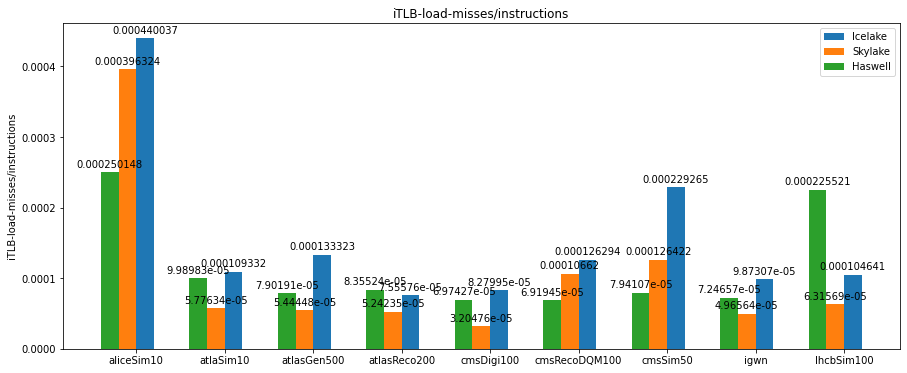

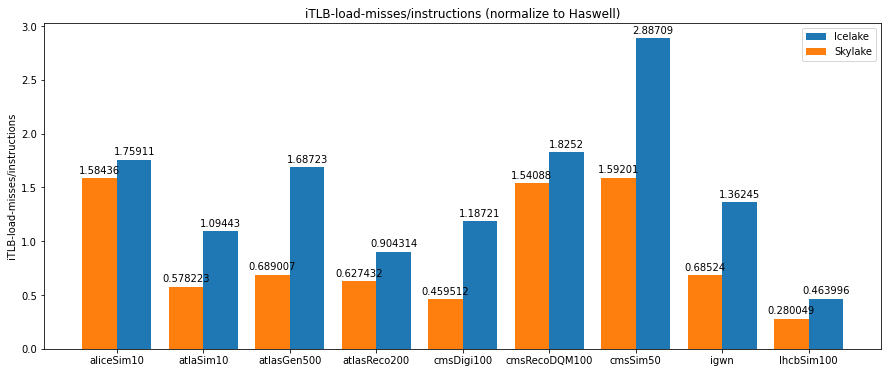

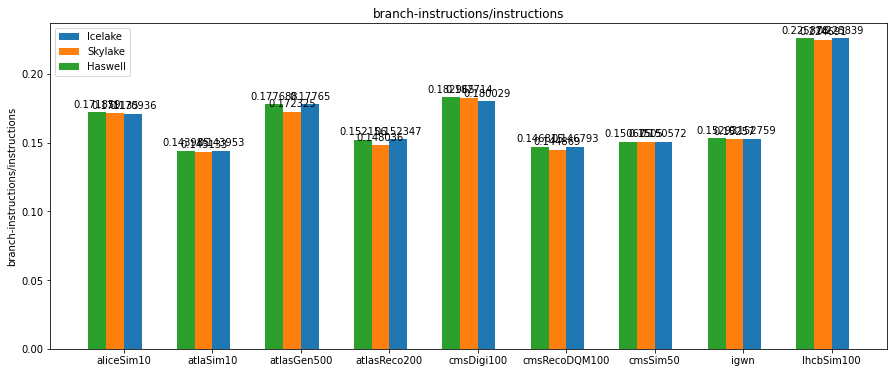

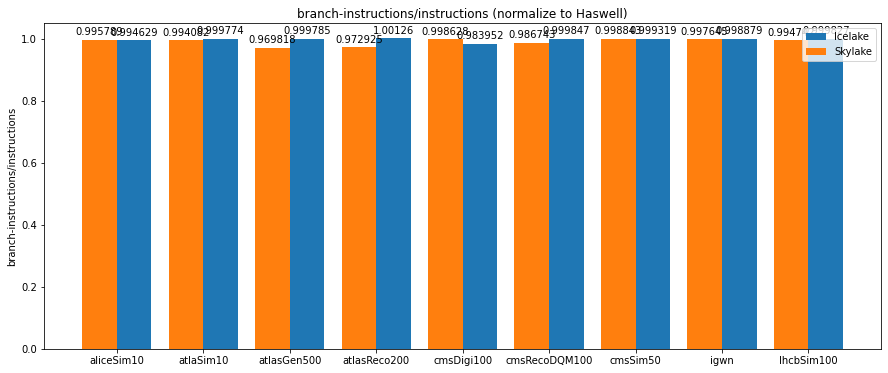

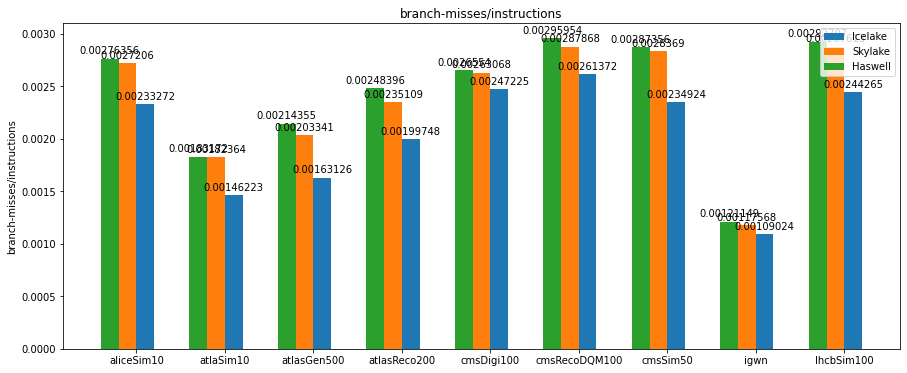

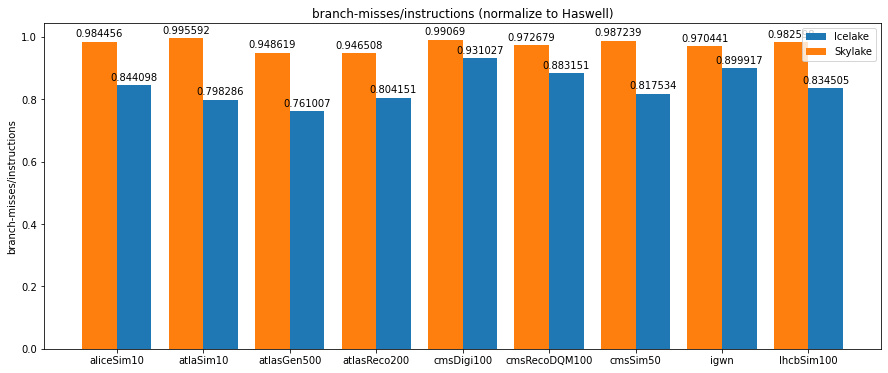

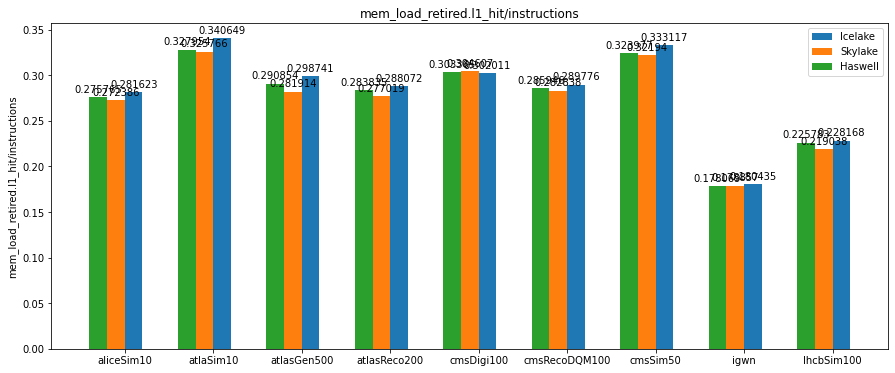

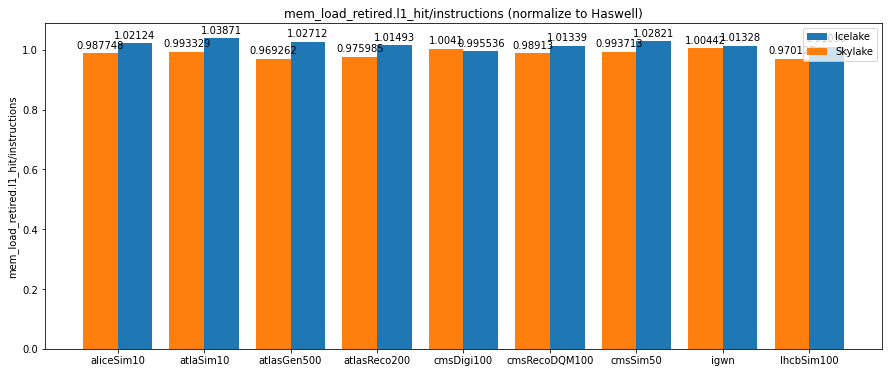

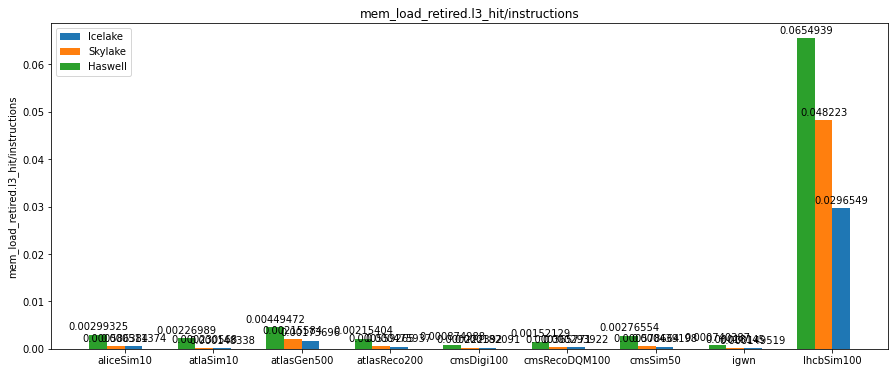

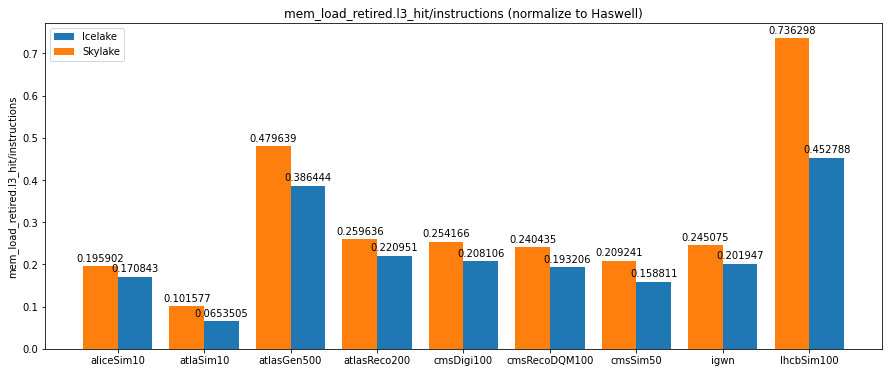

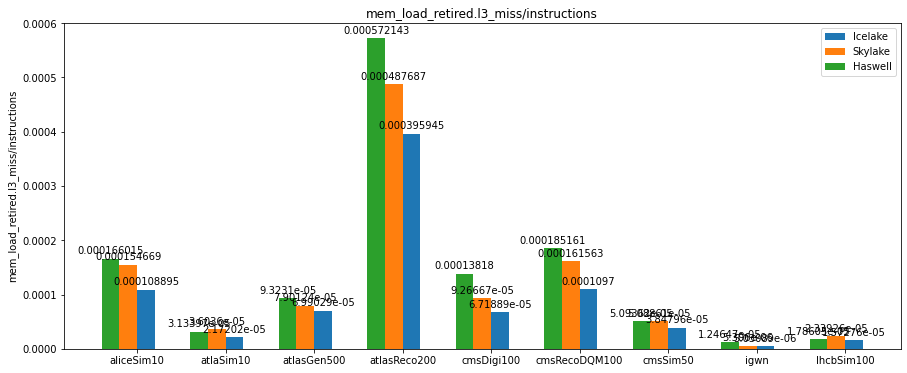

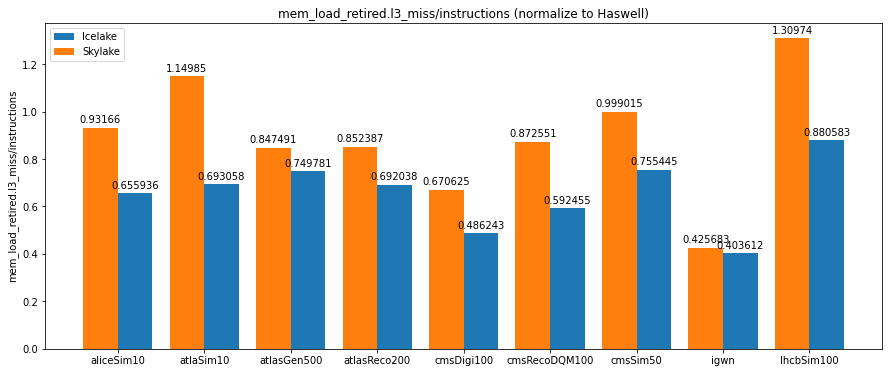

In [141]:
plotIt('wall-clock-ns',3)
plotIt('instructions',3)
plotIt('cycles',3)
plotIt('instructions',0)
plotIt('instructions',2)
plotIt('nsec',2)
plotIt('uops_executed.stall_cycles',0)
plotIt('uops_executed.cycles_ge_4',0)
plotIt('uops_executed.cycles_ge_2',0)
plotIt('uops_executed.cycles_ge_1',0)
plotIt('rs_events.empty_cycles',0)
plotIt('icache.ifdata_stall',0)
plotIt('iTLB-load-misses',1)
plotIt('branch-instructions',1)
plotIt('branch-misses',1)
plotIt('mem_load_retired.l1_hit',1)
plotIt('mem_load_retired.l3_hit',1)
plotIt('mem_load_retired.l3_miss',1)



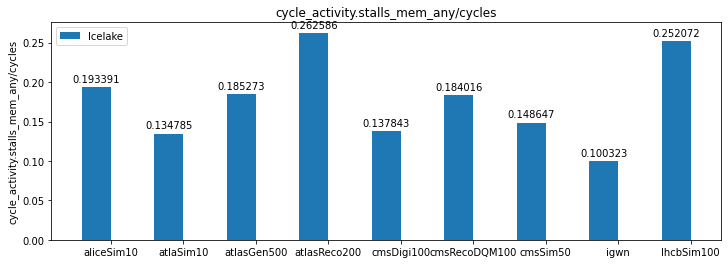

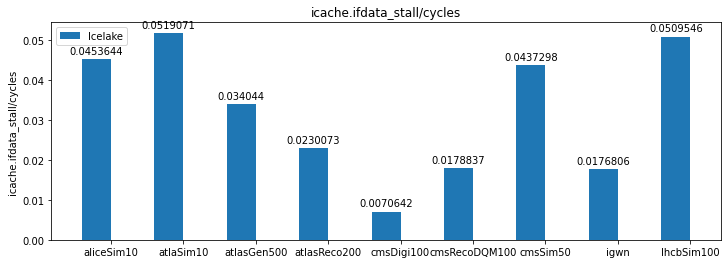

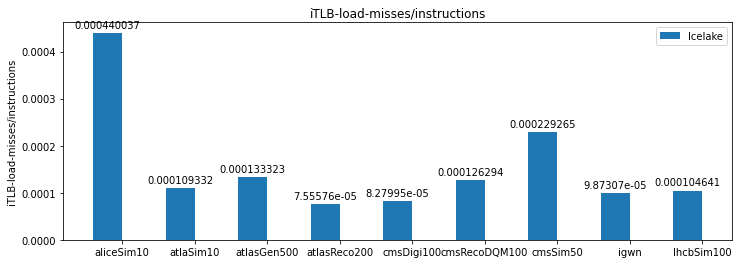

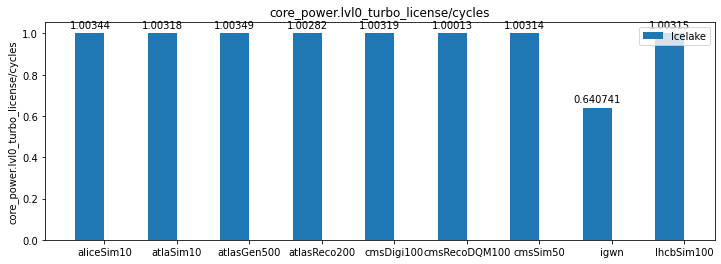

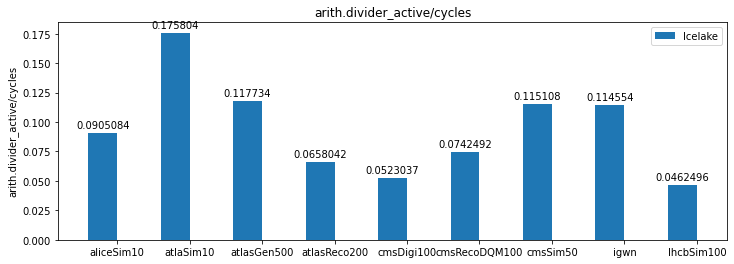

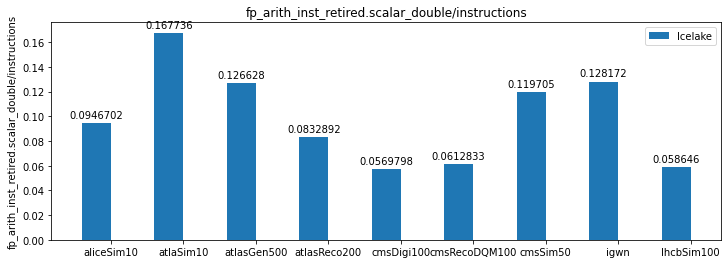

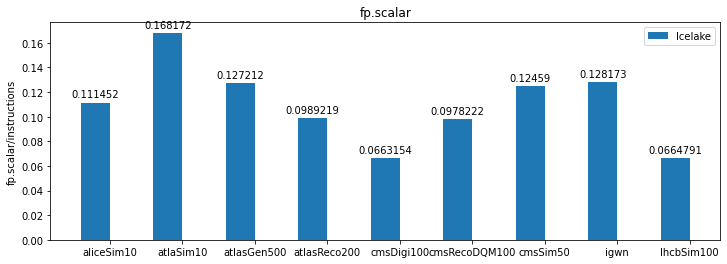

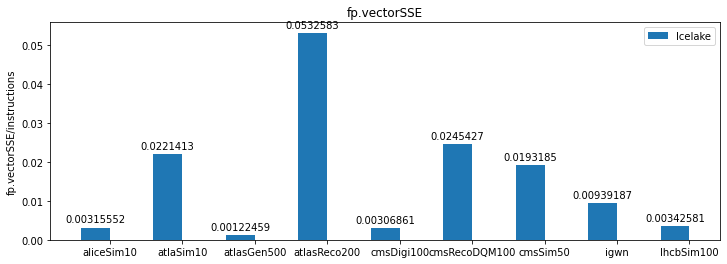

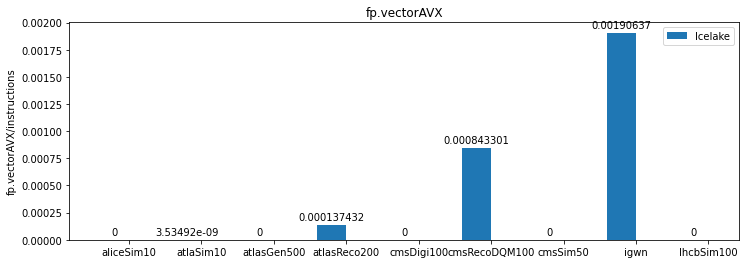

In [142]:
plotOne('cycle_activity.stalls_mem_any',0)
plotOne('icache.ifdata_stall',0)
plotOne('iTLB-load-misses',1)
plotOne('core_power.lvl0_turbo_license',0)
plotOne('arith.divider_active',0)
plotOne('fp_arith_inst_retired.scalar_double',1)
plotSum(['fp_arith_inst_retired.scalar_single','fp_arith_inst_retired.scalar_double'],1,'fp.scalar')
plotSum(['fp_arith_inst_retired.128b_packed_single','fp_arith_inst_retired.128b_packed_double'],1,'fp.vectorSSE')
plotSum(['fp_arith_inst_retired.256b_packed_single','fp_arith_inst_retired.256b_packed_double','fp_arith_inst_retired.512b_packed_single','fp_arith_inst_retired.512b_packed_double'],1,'fp.vectorAVX')